#Geolocating Digital Refugees: Twitter User Behavior During Disasters

Import necessary libraries

In [ ]:
import os
import pandas as pd
from geopy.distance import great_circle

Read our csv file that contains the human mobility data, mount google drive first, please upload your own file path.

In [ ]:
#open file csv as a dataframe
file_path = '/content/drive/MyDrive/Fall 2024 Classes/Data_science/final project death /natural_disaster_human_mobility.csv'

#make sure to separate this into different cells.

In [ ]:
#open file csv as a dataframe
df = pd.read_csv(file_path)
df.head()

disaster.event  user.anon    latitude  longitude.anon                 time
0       01_Wipha          0  139.742561       24.515364  2013-10-20 10:46:03
1       01_Wipha          0  139.702880       24.569996  2013-10-20 18:04:00
2       01_Wipha          0  139.701482       24.550507  2013-10-20 18:04:47
3       01_Wipha          0  139.728029       24.508685  2013-10-20 18:14:42
4       01_Wipha          0  139.702315       24.576521  2013-10-04 20:16:17

Next, let's explore the data and do some preprocessing to make sure the labels are understandable.

In [ ]:
#group by unique types of disaster.event
df['disaster.event'].unique()

array(['01_Wipha', '02_Halong', '06_Kalmaegi', '08_Rammasun_Manila',
       '12_Bohol', '13_Iquique', '14_Napa', '21_Norfolk', '22_Hamburg',
       '23_Atlanta', '31_Phoenix', '32_Detroit', '33_Baltimore',
       '41_AuFire1', '42_AuFire2'], dtype=object)

Above, we can see that the unique values of the disaster.event column shows names of cities and the name of the unique weather events. We want to separate these into particular locations in a separate column.

Let's load a new dataset with csv data that includes the types of disaster events AND the location data on each of the events.

In [ ]:
file_path_reference= '/content/drive/MyDrive/Fall 2024 Classes/Data_science/final project death /disaster_tweets_data_corrected.csv'

In [ ]:
#load this data into a dataframe and display the table
df_reference = pd.read_csv(file_path_reference)
df_reference.head(16)

Type                 Name                        Location  \
0        Typhoon        Wipha (Tokyo)                    Tokyo, Japan   
1        Typhoon     Halong (Okinawa)                  Okinawa, Japan   
2        Typhoon  Kalmaegi (Calasiao)           Calasiao, Philippines   
3        Typhoon    Rammasun (Manila)             Manila, Philippines   
4     Earthquake        Bohol (Bohol)              Bohol, Philippines   
5     Earthquake    Iquique (Iquique)                  Iquique, Chile   
6     Earthquake          Napa (Napa)                       Napa, USA   
7   Winter storm      Xaver (Norfolk)                Norfolk, Britain   
8   Winter storm      Xaver (Hamburg)                Hamburg, Germany   
9   Thunderstorm      Storm (Atlanta)                    Atlanta, USA   
10  Thunderstorm      Storm (Phoenix)                    Phoenix, USA   
11  Thunderstorm      Storm (Detroit)                    Detroit, USA   
12  Thunderstorm    Storm (Baltimore)                  Baltimore, USA   
13      Wildfire  New South Wales (1)  New South Wales, Australia (1)   
14      Wildfire  New South Wales (2)  New South Wales, Australia (2)   

    No. of Tweets  No. of Users  
0          849173         73451  
1          166325          5124  
2           21698          1063  
3          408760         27753  
4          114606          7942  
5           15297          1470  
6           38019          1850  
7          115018          8498  
8           15054          2745  
9          157179         15783  
10         579735         23132  
11         765353         15949  
12         328881         14582  
13          64371          9246  
14          34157          4147

Next step, we need to convert the strings of the 'disaster.event' column in the df dataframe, instead the names of the 'Name' column in the df_reference.

In [ ]:
# Create a mapping from the second dataframe (reference)
event_reference = {
    '01_Wipha': 'Wipha (Tokyo)',
    '02_Halong': 'Halong (Okinawa)',
    '06_Kalmaegi': 'Kalmaegi (Calasiao)',
    '08_Rammasun_Manila': 'Rammasun (Manila)',
    '12_Bohol': 'Bohol (Bohol)',
    '13_Iquique': 'Iquique (Iquique)',
    '14_Napa': 'Napa (Napa)',
    '21_Norfolk': 'Xaver (Norfolk)',
    '22_Hamburg': 'Xaver (Hamburg)',
    '23_Atlanta': 'Storm (Atlanta)',
    '31_Phoenix': 'Storm (Phoenix)',
    '32_Detroit': 'Storm (Detroit)',
    '33_Baltimore': 'Storm (Baltimore)',
    '41_AuFire1': 'New South Wales (1)',
    '42_AuFire2': 'New South Wales (2)'
}

In [ ]:
# Replace the values in disaster.event with the mapping from event_reference
df['disaster.event'] = df['disaster.event'].replace(event_reference)

# Display the updated dataframe
print(df.head())

  disaster.event  user.anon    latitude  longitude.anon                 time
0  Wipha (Tokyo)          0  139.742561       24.515364  2013-10-20 10:46:03
1  Wipha (Tokyo)          0  139.702880       24.569996  2013-10-20 18:04:00
2  Wipha (Tokyo)          0  139.701482       24.550507  2013-10-20 18:04:47
3  Wipha (Tokyo)          0  139.728029       24.508685  2013-10-20 18:14:42
4  Wipha (Tokyo)          0  139.702315       24.576521  2013-10-04 20:16:17


In [ ]:
#let's check the new dataframe and see the unique values for the disaster.event
df['disaster.event'].unique()

array(['Wipha (Tokyo)', 'Halong (Okinawa)', 'Kalmaegi (Calasiao)',
       'Rammasun (Manila)', 'Bohol (Bohol)', 'Iquique (Iquique)',
       'Napa (Napa)', 'Xaver (Norfolk)', 'Xaver (Hamburg)',
       'Storm (Atlanta)', 'Storm (Phoenix)', 'Storm (Detroit)',
       'Storm (Baltimore)', 'New South Wales (1)', 'New South Wales (2)'],
      dtype=object)

Make new columns, being Type, or the type of storm, and the Location being the city/state or country.

In [ ]:
# Create the mapping dictionary from df_reference
# Assuming your columns are named 'Name', 'Type', and 'Location'
event_to_type_location = dict(zip(df_reference['Name'], zip(df_reference['Type'], df_reference['Location'])))  # Use 'Name' instead of 'Event'

# Replace the disaster.event column in df with the corresponding (Type, Location) from the dictionary
# This will add the 'Type' and 'Location' as two new columns
# Handle NaN values by filling with a default or removing them
# Use fillna with a dictionary to replace NaN in 'Type' and 'Location' columns separately
result = df['disaster.event'].map(event_to_type_location) # First, apply the mapping
df['Type'] = result.apply(lambda x: x[0] if isinstance(x, tuple) else '') # Extract Type, handling NaNs
df['Location'] = result.apply(lambda x: x[1] if isinstance(x, tuple) else '') # Extract Location, handling NaNs



# Display the updated dataframe
print(df.head())

  disaster.event  user.anon    latitude  longitude.anon                 time  \
0  Wipha (Tokyo)          0  139.742561       24.515364  2013-10-20 10:46:03   
1  Wipha (Tokyo)          0  139.702880       24.569996  2013-10-20 18:04:00   
2  Wipha (Tokyo)          0  139.701482       24.550507  2013-10-20 18:04:47   
3  Wipha (Tokyo)          0  139.728029       24.508685  2013-10-20 18:14:42   
4  Wipha (Tokyo)          0  139.702315       24.576521  2013-10-04 20:16:17   

      Type      Location  
0  Typhoon  Tokyo, Japan  
1  Typhoon  Tokyo, Japan  
2  Typhoon  Tokyo, Japan  
3  Typhoon  Tokyo, Japan  
4  Typhoon  Tokyo, Japan  


In [ ]:
df.shape

(4686154, 7)

In [ ]:
df['Type'].unique()

array(['Typhoon', 'Earthquake', 'Winter storm', 'Thunderstorm',
       'Wildfire'], dtype=object)

In [ ]:
df['Location'].unique()

array(['Tokyo, Japan', 'Okinawa, Japan', 'Calasiao, Philippines',
       'Manila, Philippines', 'Bohol, Philippines', 'Iquique, Chile',
       'Napa, USA', 'Norfolk, Britain', 'Hamburg, Germany',
       'Atlanta, USA', 'Phoenix, USA', 'Detroit, USA', 'Baltimore, USA',
       'New South Wales, Australia (1)', 'New South Wales, Australia (2)'],
      dtype=object)

In [ ]:
#return the number of unique values
df['Location'].nunique() #checks into 15 values like we want.

15

#CHECKPOINT

We are now saving the new dataframe as a new csv file. This will make it easier for us to analyze the data without having to do more processing. But for me, since we already have the dataframe on the runtime, let's continue to do the analysis.

New name: disasters_2_processed.csv

Errors: Found out that the original dataset switched the lat and lon columns... switch it back for this analysis.

In [ ]:
import pandas as pd

In [ ]:
#save new datafr as a csv file?
df.to_csv('disasters_2_processed.csv', index=False)

NameError: name 'df' is not defined

**Hold** only do this step if you have the file and you want to skip the above steps.

In [ ]:
# only use this if you just want to load the new csv file as the new df

df=pd.read_csv('/content/drive/MyDrive/Fall 2024 Classes/Data_science/final project death /disasters_2_processed.csv')
df.head()

disaster.event  user.anon    latitude  longitude.anon                 time  \
0  Wipha (Tokyo)          0  139.742561       24.515364  2013-10-20 10:46:03   
1  Wipha (Tokyo)          0  139.702880       24.569996  2013-10-20 18:04:00   
2  Wipha (Tokyo)          0  139.701482       24.550507  2013-10-20 18:04:47   
3  Wipha (Tokyo)          0  139.728029       24.508685  2013-10-20 18:14:42   
4  Wipha (Tokyo)          0  139.702315       24.576521  2013-10-04 20:16:17   

      Type      Location  
0  Typhoon  Tokyo, Japan  
1  Typhoon  Tokyo, Japan  
2  Typhoon  Tokyo, Japan  
3  Typhoon  Tokyo, Japan  
4  Typhoon  Tokyo, Japan

In [ ]:
#making sure to switch the column named of lon and lat to the right names
df.rename(columns={'latitude': 'longitude.anon', 'longitude.anon': 'latitude'}, inplace=True)

# Print the updated dataframe to confirm the column names are swapped
df.head()

disaster.event  user.anon  longitude.anon   latitude                 time  \
0  Wipha (Tokyo)          0      139.742561  24.515364  2013-10-20 10:46:03   
1  Wipha (Tokyo)          0      139.702880  24.569996  2013-10-20 18:04:00   
2  Wipha (Tokyo)          0      139.701482  24.550507  2013-10-20 18:04:47   
3  Wipha (Tokyo)          0      139.728029  24.508685  2013-10-20 18:14:42   
4  Wipha (Tokyo)          0      139.702315  24.576521  2013-10-04 20:16:17   

      Type      Location  
0  Typhoon  Tokyo, Japan  
1  Typhoon  Tokyo, Japan  
2  Typhoon  Tokyo, Japan  
3  Typhoon  Tokyo, Japan  
4  Typhoon  Tokyo, Japan

Converting the time to the right datetime format

At least one time entry in the column (140024) doesn't contain the time part, just the date. We should try to figure out when this is happening... Because the error arised AFTER the function got to row 140024.

In [ ]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['time'] = df['time'].fillna(pd.to_datetime(df['time'].dt.date)) #If there are any NaT (Not a Time) values, this line replaces them with the date part of the original 'time' column values.

In [ ]:
#find the NaT values and count them
df[df['time'].isna()].shape

(1, 7)

There is only one NaT value, so now let's delete the one row that is showing the NaT value. For reference, this is position 140024 in Wipha(Tokyo)

In [ ]:
#return the NaT value from the 'time' column
df[df['time'].isna()]

disaster.event  user.anon  longitude.anon   latitude time     Type  \
140024  Wipha (Tokyo)          0      139.763321  24.571198  NaT  Typhoon   

            Location  
140024  Tokyo, Japan

In [ ]:
#delete position 140024 since it has an NaT value
df = df.drop(140024)

In [ ]:
#print out the shape of the df
df.shape


(4686153, 7)

The new shape of the dataframe, 'df' should be (4686153, 7)

#Research Questions

Q1: During disaster events, how far are Twitter users migrating on one disaster event? What is the averages of migration among the different types of disaster events...

To analyze the distance traveled by users over time (before one day, during, and 5 days after the disaster starts)
after the event), we will need to calculate the distance between the points in each user's journey.


---


Q2: Can we separate these migration routes among different days?


---



Q3: Can we compare different disaster events and how far in 8 days people are migrating from the epicenter of a disaster?

##Q1: Is the average distance users migrate from the epicenter of a disaster different from day 1?

In [ ]:
df.head()

disaster.event  user.anon  longitude.anon   latitude                time  \
0  Wipha (Tokyo)          0      139.742561  24.515364 2013-10-20 10:46:03   
1  Wipha (Tokyo)          0      139.702880  24.569996 2013-10-20 18:04:00   
2  Wipha (Tokyo)          0      139.701482  24.550507 2013-10-20 18:04:47   
3  Wipha (Tokyo)          0      139.728029  24.508685 2013-10-20 18:14:42   
4  Wipha (Tokyo)          0      139.702315  24.576521 2013-10-04 20:16:17   

      Type      Location  
0  Typhoon  Tokyo, Japan  
1  Typhoon  Tokyo, Japan  
2  Typhoon  Tokyo, Japan  
3  Typhoon  Tokyo, Japan  
4  Typhoon  Tokyo, Japan

In [ ]:
#extract the year that each disaster.event happened from the df file
df['year'] = df['time'].dt.year
df.head()

disaster.event  user.anon  longitude.anon   latitude                time  \
0  Wipha (Tokyo)          0      139.742561  24.515364 2013-10-20 10:46:03   
1  Wipha (Tokyo)          0      139.702880  24.569996 2013-10-20 18:04:00   
2  Wipha (Tokyo)          0      139.701482  24.550507 2013-10-20 18:04:47   
3  Wipha (Tokyo)          0      139.728029  24.508685 2013-10-20 18:14:42   
4  Wipha (Tokyo)          0      139.702315  24.576521 2013-10-04 20:16:17   

      Type      Location  year  
0  Typhoon  Tokyo, Japan  2013  
1  Typhoon  Tokyo, Japan  2013  
2  Typhoon  Tokyo, Japan  2013  
3  Typhoon  Tokyo, Japan  2013  
4  Typhoon  Tokyo, Japan  2013

In [ ]:
#group by each unique value in disaster.event in the 'disaster.event' column, print out the years associated with them
df.groupby('disaster.event')['year'].unique()


disaster.event
Bohol (Bohol)          [2013]
Halong (Okinawa)       [2014]
Iquique (Iquique)      [2014]
Kalmaegi (Calasiao)    [2014]
Napa (Napa)            [2014]
New South Wales (1)    [2013]
New South Wales (2)    [2013]
Rammasun (Manila)      [2014]
Storm (Atlanta)        [2014]
Storm (Baltimore)      [2014]
Storm (Detroit)        [2014]
Storm (Phoenix)        [2014]
Wipha (Tokyo)          [2013]
Xaver (Hamburg)        [2013]
Xaver (Norfolk)        [2013]
Name: year, dtype: object

###Create a new dataframe for each disaster that contains the disaster, the start time of the event (by one day before considering the warnings) and create a new column in the dataframe that contains the epicenter (long and lat) of the approximate disaster location

####df_event_start_location
is the new dataframe so we can reference all of the events' start dates, and the latitude and longitude.

In [ ]:
# Initialize the new dataframe manually
data = {
    "disaster.event": [
        "Wipha (Tokyo)", "Halong (Okinawa)", "Kalmaegi (Calasiao)", "Rammasun (Manila)",
        "Bohol (Bohol)", "Iquique (Iquique)", "Napa (Napa)", "Xaver (Norfolk)",
        "Xaver (Hamburg)", "Storm (Atlanta)", "Storm (Phoenix)", "Storm (Detroit)",
        "Storm (Baltimore)", "New South Wales (1)", "New South Wales (2)"
    ],
    "event_start_date": [
        "2013-10-09", "2014-08-07", "2014-09-13", "2014-07-11",
        "2013-10-15", "2014-04-01", "2014-08-24", "2013-12-05",
        "2013-12-04", "2014-01-28", "2014-09-08", "2014-08-11",
        "2014-07-28", "2013-10-13", "2013-10-13"
    ],
    "latitude": [
        35.689487, 26.212313, 16.0082453, 14.6042,
        9.880, -19.610, 38.217, 52.6140,
        53.5488, 33.7501, 33.4484, 42.3314,
        39.2904, -31.2532, -31.2532
    ],
    "longitude.anon": [
        139.691711, 127.679153, 120.3578634, 120.9822,
        124.117, -70.769, -122.3105, 0.8864,
        9.9872, -84.3885, -112.0740, -83.0458,
        -76.6122, 146.9211, 146.9211
    ]
}

# Creating the dataframe
df_event_start_location = pd.DataFrame(data)

# Display the dataframe
print(df_event_start_location)

         disaster.event event_start_date   latitude  longitude.anon
0         Wipha (Tokyo)       2013-10-09  35.689487      139.691711
1      Halong (Okinawa)       2014-08-07  26.212313      127.679153
2   Kalmaegi (Calasiao)       2014-09-13  16.008245      120.357863
3     Rammasun (Manila)       2014-07-11  14.604200      120.982200
4         Bohol (Bohol)       2013-10-15   9.880000      124.117000
5     Iquique (Iquique)       2014-04-01 -19.610000      -70.769000
6           Napa (Napa)       2014-08-24  38.217000     -122.310500
7       Xaver (Norfolk)       2013-12-05  52.614000        0.886400
8       Xaver (Hamburg)       2013-12-04  53.548800        9.987200
9       Storm (Atlanta)       2014-01-28  33.750100      -84.388500
10      Storm (Phoenix)       2014-09-08  33.448400     -112.074000
11      Storm (Detroit)       2014-08-11  42.331400      -83.045800
12    Storm (Baltimore)       2014-07-28  39.290400      -76.612200
13  New South Wales (1)       2013-10-13 -31.253

Now that we have the reference dataframe for the disaster locations and start times, let's choose a disaster event, but first, let's initialize the disaster.event so we can reframe and replicate the analysis if we choose a different one later.

#####Important: Make sure to initialize the variables for analysis

In [ ]:
disaster_event_name='Wipha (Tokyo)' #insert the disaster_event_name you'd want
number_of_days=5 #insert the number of days you want to analyze
#make a new variable that is just the event_start_date value for the Wipha(Tokyo)/another disaster
event_start_date = df_event_start_location[df_event_start_location['disaster.event'] == disaster_event_name]['event_start_date'].values[0]
event_start_date = pd.to_datetime(event_start_date) #convert to datetime
event_start_date

Timestamp('2013-10-09 00:00:00')

In [ ]:
df_Wipha = df[df['disaster.event'] == disaster_event_name]
df_Wipha.head()

disaster.event  user.anon  longitude.anon   latitude                time  \
0  Wipha (Tokyo)          0      139.742561  24.515364 2013-10-20 10:46:03   
1  Wipha (Tokyo)          0      139.702880  24.569996 2013-10-20 18:04:00   
2  Wipha (Tokyo)          0      139.701482  24.550507 2013-10-20 18:04:47   
3  Wipha (Tokyo)          0      139.728029  24.508685 2013-10-20 18:14:42   
4  Wipha (Tokyo)          0      139.702315  24.576521 2013-10-04 20:16:17   

      Type      Location  year  
0  Typhoon  Tokyo, Japan  2013  
1  Typhoon  Tokyo, Japan  2013  
2  Typhoon  Tokyo, Japan  2013  
3  Typhoon  Tokyo, Japan  2013  
4  Typhoon  Tokyo, Japan  2013

In [ ]:
#make a new dataframe for df_Wipha that only includes data during event_start_date and before 5 days by comparing days
df_Wipha = df_Wipha[df_Wipha['time'] >= event_start_date]
#df_Wipha = df_Wipha[df_Wipha['time'] < event_start_date + pd.Timedelta(days=number_of_days)]
df_Wipha.head()

disaster.event  user.anon  longitude.anon   latitude                time  \
0   Wipha (Tokyo)          0      139.742561  24.515364 2013-10-20 10:46:03   
1   Wipha (Tokyo)          0      139.702880  24.569996 2013-10-20 18:04:00   
2   Wipha (Tokyo)          0      139.701482  24.550507 2013-10-20 18:04:47   
3   Wipha (Tokyo)          0      139.728029  24.508685 2013-10-20 18:14:42   
10  Wipha (Tokyo)          0      139.776113  24.504277 2013-10-28 21:25:14   

       Type      Location  year  
0   Typhoon  Tokyo, Japan  2013  
1   Typhoon  Tokyo, Japan  2013  
2   Typhoon  Tokyo, Japan  2013  
3   Typhoon  Tokyo, Japan  2013  
10  Typhoon  Tokyo, Japan  2013

In [ ]:
df_Wipha.shape

(1038922, 8)

In [ ]:
# Epicenter coordinates for Wipha (Tokyo)
epicenter_row = df_event_start_location[df_event_start_location['disaster.event'] == disaster_event_name]
epicenter_coords = (epicenter_row['latitude'].values[0], epicenter_row['longitude.anon'].values[0])
epicenter_coords




(35.689487, 139.691711)

In [ ]:
# Calculate the great circle distance for each user
df_Wipha['distance_from_epicenter'] = df_Wipha.apply(
    lambda x: great_circle((x['latitude'], x['longitude.anon']), epicenter_coords).km,
    axis=1
)

In [ ]:
# Create a column for the day based on the 'time' column
df_Wipha['days_since_disaster'] = (df_Wipha['time'] - pd.to_datetime(event_start_date)).dt.days
df_Wipha.head()

disaster.event  user.anon  longitude.anon   latitude                time  \
0   Wipha (Tokyo)          0      139.742561  24.515364 2013-10-20 10:46:03   
1   Wipha (Tokyo)          0      139.702880  24.569996 2013-10-20 18:04:00   
2   Wipha (Tokyo)          0      139.701482  24.550507 2013-10-20 18:04:47   
3   Wipha (Tokyo)          0      139.728029  24.508685 2013-10-20 18:14:42   
10  Wipha (Tokyo)          0      139.776113  24.504277 2013-10-28 21:25:14   

       Type      Location  year  distance_from_epicenter  days_since_disaster  
0   Typhoon  Tokyo, Japan  2013              1242.517080                   11  
1   Typhoon  Tokyo, Japan  2013              1236.433181                   11  
2   Typhoon  Tokyo, Japan  2013              1238.600191                   11  
3   Typhoon  Tokyo, Japan  2013              1243.255142                   11  
10  Typhoon  Tokyo, Japan  2013              1243.766741                   19

In [ ]:
# Categorize days (Day 1, Day 2, etc.)
df_Wipha['day'] = df_Wipha['days_since_disaster'].apply(lambda x: f"Day {x + 1}" if x >= 0 else 'Pre-Disaster')

# View the updated dataframe
print(df_Wipha[['user.anon', 'time', 'distance_from_epicenter', 'day']].head())
df_Wipha.shape

    user.anon                time  distance_from_epicenter     day
0           0 2013-10-20 10:46:03              1242.517080  Day 12
1           0 2013-10-20 18:04:00              1236.433181  Day 12
2           0 2013-10-20 18:04:47              1238.600191  Day 12
3           0 2013-10-20 18:14:42              1243.255142  Day 12
10          0 2013-10-28 21:25:14              1243.766741  Day 20


(1038922, 11)

Now that we made new columns for df_Wipha, let's groupby means per day of the users experiencing the Wipha typhoon in Tokyo.

In [ ]:
# Group by the 'day' and calculate the average distance for each day
avg_distance_by_day = df_Wipha.groupby('day')['distance_from_epicenter'].mean()

# Print the average distances for each day
print(avg_distance_by_day)

day
Day 1      994.707226
Day 10     990.426890
Day 11    1001.832026
Day 12     998.686689
Day 13    1000.340859
Day 14     989.921692
Day 15     991.450488
Day 16     995.289911
Day 17     998.551871
Day 18     997.440113
Day 19     998.582558
Day 2      994.102650
Day 20     992.329579
Day 21     986.378020
Day 22     987.786908
Day 23     991.053515
Day 24     972.732294
Day 28     985.311631
Day 29     985.030650
Day 3      990.789849
Day 30     985.085015
Day 4     1003.505035
Day 5      995.973565
Day 6      998.612888
Day 7      996.768439
Day 8     1001.077071
Day 9      998.643674
Name: distance_from_epicenter, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Sort the average distance by numerical day order
avg_distance_by_day.index = avg_distance_by_day.index.str.extract(r'(\d+)')[0].astype(int)  # Extract numeric part from 'Day X' and select the first column (series)
avg_distance_by_day = avg_distance_by_day.sort_index()

###Q1 Scatterplots

Below, we can see that we have plotted all of the recorded days for the Wipha Tokyo Typhoon disaster. We can see a lot of dips, but since we only care about the disaster responses by individuals on a few days after the disaster starts, I only want to use a week (7 days) for our data.

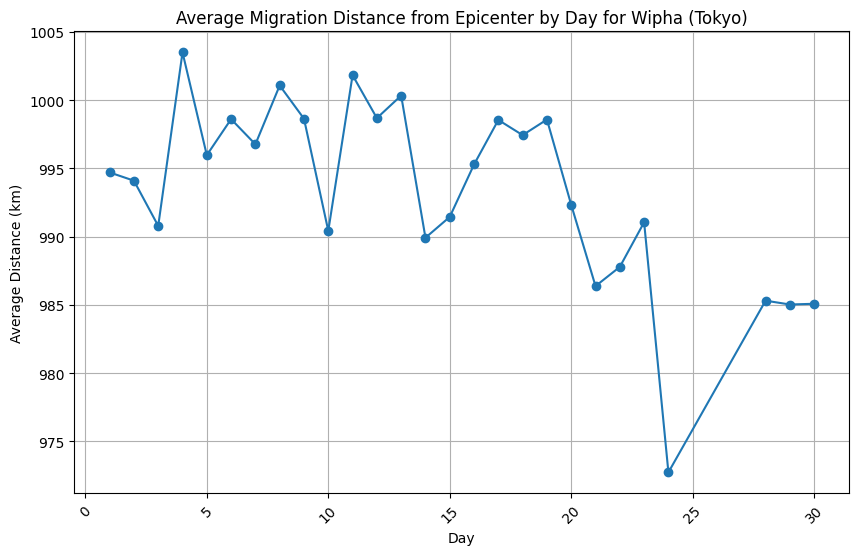

In [ ]:
# Plot the average distance by day, make the title to change with the disaster_event
plt.figure(figsize=(10, 6))
avg_distance_by_day.plot(kind='line', marker='o')
plt.title(f'Average Migration Distance from Epicenter by Day for {disaster_event_name}')
plt.xlabel('Day')
plt.ylabel('Average Distance (km)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


We can see below that when we zoom into the average migration distance, it seems to spike around day 4 since the start of the Wipha Typhoon.

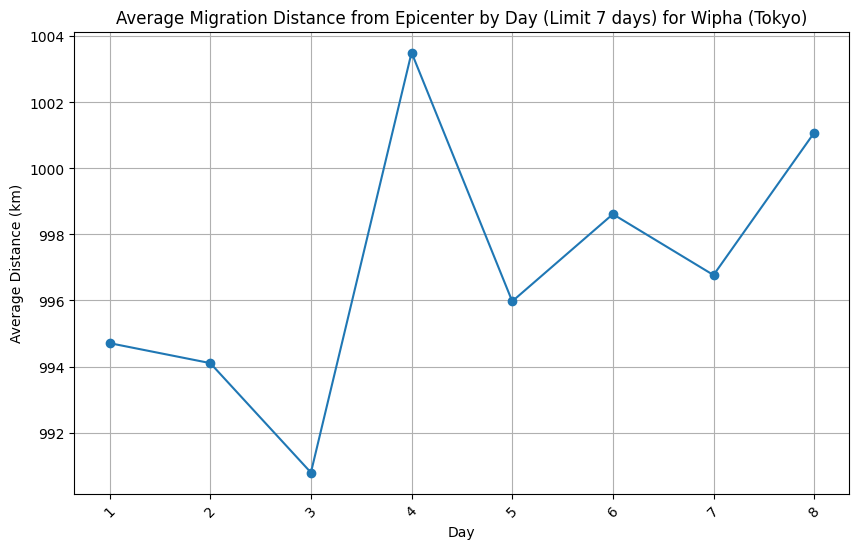

In [ ]:
#plot the same plot above but only plot from days 0-8
plt.figure(figsize=(10, 6))
avg_distance_by_day[:8].plot(kind='line', marker='o')

plt.title(f'Average Migration Distance from Epicenter by Day (Limit 7 days) for {disaster_event_name}')
plt.xlabel('Day')
plt.ylabel('Average Distance (km)')
plt.xticks(rotation=45)
plt.grid(True)

### More analysis on Wipha Tokyo
Oh? You don't think migrating on average 1000+ km between the 3rd and 4th day since the landfall of the Wipha Typhoon in Tokyo is significant? What is the likelihood that this migration away from the epicenter of the Typhoon landfall in Tokyo a coincidence?

In [ ]:
from scipy.stats import ttest_ind

day1_distances = df_Wipha[df_Wipha['day'] == 'Day 1']['distance_from_epicenter']
other_days_distances = df_Wipha[df_Wipha['day'] == 'Day 4']['distance_from_epicenter']
t_stat, p_value = ttest_ind(day1_distances, other_days_distances, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: -3.7206163215765073, P-value: 0.00019886349640101838


We can see above that assuming the distribution of average Twitter user distances from Tokyo Japan follows a normal distribution with a null value of 995 km from Tokyo, an average distance displacement of above 1003 km is statistically significant at a p-value of 0.000198... It would be unusual to see this distance by random error considering the averages of distances.

###Q3: Is there a difference among different types of disaster events and how long in time and how far people are migrating (or not migrating at all?)

The third question is more applicable to the first research question. Now that we figured out how to get the average distances among the users on day 1-end for one particular disaster (Wipha, Tokyo), we want to figure out if these changes in distances are different among all of the disasters.

---

1.   Fit scatterplots of each disaster.event AND find the lines of best fits only from day 0-day 8
2.   Use the slopes regardless of intercept values, since the slope would indicate a different change of distance among the same times displacements. The slopes values will represent each disaster.event, make the labels hoverable for the disaster.event
3.   Plot the slopes in a scatterplot:
*   using the GDP per Capita as x-axis
*   using the disaster event as the x-axis
*   using the type of disaster as the x-axis or color coded into the plot


      






In [ ]:
df.head() #we are using this dataframe from the original one

disaster.event  user.anon  longitude.anon   latitude                time  \
0  Wipha (Tokyo)          0      139.742561  24.515364 2013-10-20 10:46:03   
1  Wipha (Tokyo)          0      139.702880  24.569996 2013-10-20 18:04:00   
2  Wipha (Tokyo)          0      139.701482  24.550507 2013-10-20 18:04:47   
3  Wipha (Tokyo)          0      139.728029  24.508685 2013-10-20 18:14:42   
4  Wipha (Tokyo)          0      139.702315  24.576521 2013-10-04 20:16:17   

      Type      Location  year  
0  Typhoon  Tokyo, Japan  2013  
1  Typhoon  Tokyo, Japan  2013  
2  Typhoon  Tokyo, Japan  2013  
3  Typhoon  Tokyo, Japan  2013  
4  Typhoon  Tokyo, Japan  2013

Since we're processing multiple disasters at once, let's make a function that creates a merged dataframe

In [ ]:
# Create an empty list to store filtered data for each disaster event
filtered_data_list = []

# Loop through each unique disaster event in df_event_start_location
for disaster_event in df_event_start_location['disaster.event'].unique():
    # Get the event start date for the current disaster
    event_start_date = df_event_start_location[df_event_start_location['disaster.event'] == disaster_event]['event_start_date'].values[0]

    # Filter the main dataframe for the current disaster event
    df_event = df[df['disaster.event'] == disaster_event].copy()  # Use copy to avoid SettingWithCopyWarning

    # Calculate the days since the event started for each row
    df_event['days_since_disaster'] = (df_event['time'] - pd.to_datetime(event_start_date)).dt.days

    # Filter for data within day 0 to day 8
    df_filtered_event = df_event[(df_event['days_since_disaster'] >= 0) & (df_event['days_since_disaster'] <= 8)]

    # Append the filtered data for this disaster event to the list
    filtered_data_list.append(df_filtered_event)

# Concatenate all filtered dataframes into one
df_filtered_all = pd.concat(filtered_data_list)

# Check the head of the final filtered dataframe
df_filtered_all.head()



disaster.event  user.anon  longitude.anon   latitude                time  \
11  Wipha (Tokyo)          0      139.738485  24.517249 2013-10-14 15:49:25   
12  Wipha (Tokyo)          0      139.697556  24.549073 2013-10-14 16:22:14   
14  Wipha (Tokyo)          0      139.642395  24.518733 2013-10-10 12:15:28   
15  Wipha (Tokyo)          0      139.494139  24.403357 2013-10-12 23:54:11   
19  Wipha (Tokyo)          0      139.589367  24.640273 2013-10-11 15:50:43   

       Type      Location  year  days_since_disaster  
11  Typhoon  Tokyo, Japan  2013                    5  
12  Typhoon  Tokyo, Japan  2013                    5  
14  Typhoon  Tokyo, Japan  2013                    1  
15  Typhoon  Tokyo, Japan  2013                    3  
19  Typhoon  Tokyo, Japan  2013                    2

In [ ]:
df_filtered_all['disaster.event'].nunique() #just checking the categories of disaster.events

15

In [ ]:
# Now, merge with epicenter coordinates from df_event_start_location
df_merged = pd.merge(df_filtered_all, df_event_start_location[['disaster.event', 'latitude', 'longitude.anon']],
                     on='disaster.event', how='left', suffixes=('', '_epicenter'))
df_merged.head()

disaster.event  user.anon  longitude.anon   latitude                time  \
0  Wipha (Tokyo)          0      139.738485  24.517249 2013-10-14 15:49:25   
1  Wipha (Tokyo)          0      139.697556  24.549073 2013-10-14 16:22:14   
2  Wipha (Tokyo)          0      139.642395  24.518733 2013-10-10 12:15:28   
3  Wipha (Tokyo)          0      139.494139  24.403357 2013-10-12 23:54:11   
4  Wipha (Tokyo)          0      139.589367  24.640273 2013-10-11 15:50:43   

      Type      Location  year  days_since_disaster  latitude_epicenter  \
0  Typhoon  Tokyo, Japan  2013                    5           35.689487   
1  Typhoon  Tokyo, Japan  2013                    5           35.689487   
2  Typhoon  Tokyo, Japan  2013                    1           35.689487   
3  Typhoon  Tokyo, Japan  2013                    3           35.689487   
4  Typhoon  Tokyo, Japan  2013                    2           35.689487   

   longitude.anon_epicenter  
0                139.691711  
1                139.691711  
2                139.691711  
3                139.691711  
4                139.691711

In [ ]:
# Function to calculate the distance from the epicenter
import geopy.distance # Import geopy.distance

def calculate_distance_from_epicenter(lat, lon, epicenter_lat, epicenter_lon):
    return geopy.distance.distance((lat, lon), (epicenter_lat, epicenter_lon)).km

# Calculate the distance from the epicenter for each row
df_merged['distance_from_epicenter'] = df_merged.apply(
    lambda row: calculate_distance_from_epicenter(row['latitude'], row['longitude.anon'],
                                                  row['latitude_epicenter'], row['longitude.anon_epicenter']), axis=1
)

# Check the result
df_merged.head()

disaster.event  user.anon  longitude.anon   latitude                time  \
0  Wipha (Tokyo)          0      139.738485  24.517249 2013-10-14 15:49:25   
1  Wipha (Tokyo)          0      139.697556  24.549073 2013-10-14 16:22:14   
2  Wipha (Tokyo)          0      139.642395  24.518733 2013-10-10 12:15:28   
3  Wipha (Tokyo)          0      139.494139  24.403357 2013-10-12 23:54:11   
4  Wipha (Tokyo)          0      139.589367  24.640273 2013-10-11 15:50:43   

      Type      Location  year  days_since_disaster  latitude_epicenter  \
0  Typhoon  Tokyo, Japan  2013                    5           35.689487   
1  Typhoon  Tokyo, Japan  2013                    5           35.689487   
2  Typhoon  Tokyo, Japan  2013                    1           35.689487   
3  Typhoon  Tokyo, Japan  2013                    3           35.689487   
4  Typhoon  Tokyo, Japan  2013                    2           35.689487   

   longitude.anon_epicenter  distance_from_epicenter  
0                139.691711              1238.517299  
1                139.691711              1234.984255  
2                139.691711              1238.353894  
3                139.691711              1251.268530  
4                139.691711              1224.921692

###Compare typhoons, one with a high GDP per capita and one with a low GDP per capita in the affected area. (Wipha (Tokyo)) vs. (Kalmeagi (Calasiao))

In [ ]:
disaster_1 = "Wipha (Tokyo)"
disaster_2 = "Kalmaegi (Calasiao)"

df_two_disasters = df_merged[df_merged['disaster.event'].isin([disaster_1, disaster_2])]
df_two_disasters.head()

disaster.event  user.anon  longitude.anon   latitude                time  \
0  Wipha (Tokyo)          0      139.738485  24.517249 2013-10-14 15:49:25   
1  Wipha (Tokyo)          0      139.697556  24.549073 2013-10-14 16:22:14   
2  Wipha (Tokyo)          0      139.642395  24.518733 2013-10-10 12:15:28   
3  Wipha (Tokyo)          0      139.494139  24.403357 2013-10-12 23:54:11   
4  Wipha (Tokyo)          0      139.589367  24.640273 2013-10-11 15:50:43   

      Type      Location  year  days_since_disaster  latitude_epicenter  \
0  Typhoon  Tokyo, Japan  2013                    5           35.689487   
1  Typhoon  Tokyo, Japan  2013                    5           35.689487   
2  Typhoon  Tokyo, Japan  2013                    1           35.689487   
3  Typhoon  Tokyo, Japan  2013                    3           35.689487   
4  Typhoon  Tokyo, Japan  2013                    2           35.689487   

   longitude.anon_epicenter  distance_from_epicenter  
0                139.691711              1238.517299  
1                139.691711              1234.984255  
2                139.691711              1238.353894  
3                139.691711              1251.268530  
4                139.691711              1224.921692

In [ ]:
print(df_two_disasters.groupby('disaster.event')['distance_from_epicenter'].describe())

                        count         mean         std          min  \
disaster.event                                                        
Kalmaegi (Calasiao)   14989.0  1179.708113    3.541939  1169.874108   
Wipha (Tokyo)        382736.0   994.534172  344.420838   376.858583   

                             25%          50%          75%          max  
disaster.event                                                           
Kalmaegi (Calasiao)  1177.356625  1179.118464  1182.618529  1188.379200  
Wipha (Tokyo)         860.253019   868.099907  1230.895314  2167.879459  


In [ ]:
df_avg_distance = (
    df_two_disasters
    .groupby(['disaster.event', 'days_since_disaster'])
    .agg({'distance_from_epicenter': 'mean'})
    .reset_index()
)

In [ ]:
#print each head of the df split with the 2 disasters
print(df_avg_distance[df_avg_distance['disaster.event'] == disaster_1].head())
print(df_avg_distance[df_avg_distance['disaster.event'] == disaster_2].head())

   disaster.event  days_since_disaster  distance_from_epicenter
9   Wipha (Tokyo)                    0               991.932312
10  Wipha (Tokyo)                    1               991.325406
11  Wipha (Tokyo)                    2               988.023324
12  Wipha (Tokyo)                    3              1000.716930
13  Wipha (Tokyo)                    4               993.192931
        disaster.event  days_since_disaster  distance_from_epicenter
0  Kalmaegi (Calasiao)                    0              1180.384455
1  Kalmaegi (Calasiao)                    1              1180.356615
2  Kalmaegi (Calasiao)                    2              1180.067910
3  Kalmaegi (Calasiao)                    3              1179.748582
4  Kalmaegi (Calasiao)                    4              1179.337405


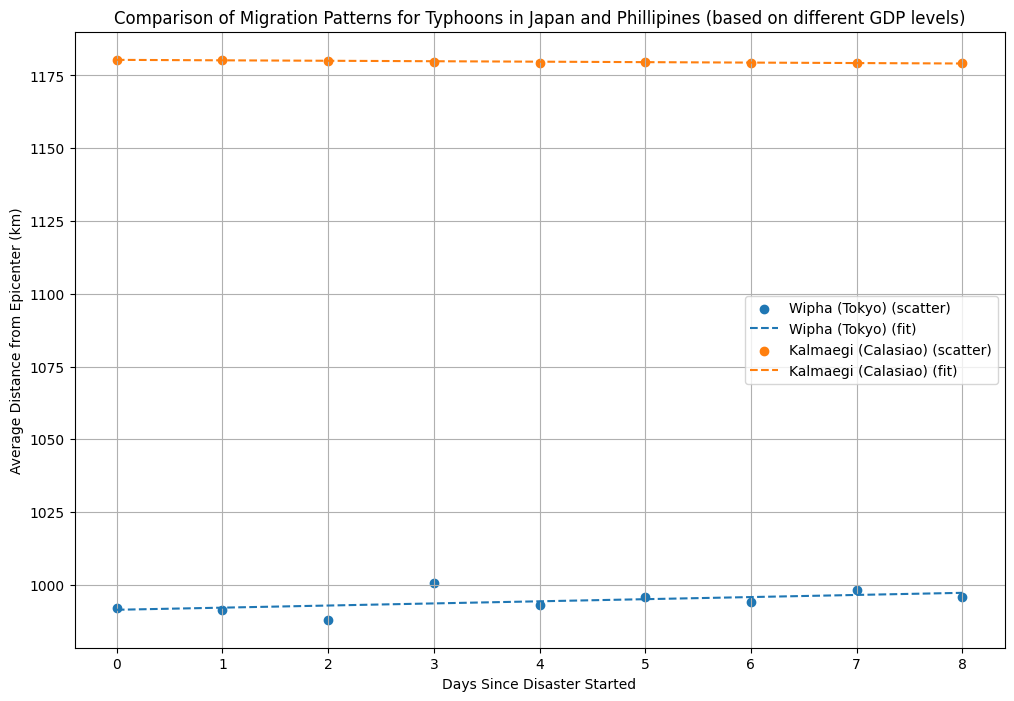

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

plt.figure(figsize=(12, 8))

for disaster_event in [disaster_1, disaster_2]:
    # Filter data for the current disaster
    df_event = df_avg_distance[df_avg_distance['disaster.event'] == disaster_event]

    # Extract X and y
    X = df_event[['days_since_disaster']]
    y = df_event['distance_from_epicenter']

    # Scatterplot of the average distances
    plt.scatter(df_event['days_since_disaster'], df_event['distance_from_epicenter'], label=f"{disaster_event} (scatter)")

    # Fit a linear regression line
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Plot the line of best fit
    plt.plot(df_event['days_since_disaster'], y_pred, label=f"{disaster_event} (fit)", linestyle='--')

# Add labels, legend, and title
plt.xlabel('Days Since Disaster Started')
plt.ylabel('Average Distance from Epicenter (km)')
plt.title('Comparison of Migration Patterns for Typhoons in Japan and Phillipines (based on different GDP levels)')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 9, 1))  # Show days 0-8
plt.show()


###Compare earthquakes, one with a high GDP per capita and one with a low GDP per capita in the affected area (Napa (Napa/SF, CA)) vs. (Bohol (Bohol))

In [ ]:
#earthquake
disaster_1='Bohol (Bohol)' #low GDP
disaster_2='Napa (Napa)' #high GDP

df_two_disasters = df_merged[df_merged['disaster.event'].isin([disaster_1, disaster_2])]

In [ ]:
print(df_two_disasters.groupby('disaster.event')['distance_from_epicenter'].describe())

                  count         mean        std          min          25%  \
disaster.event                                                              
Bohol (Bohol)   39237.0  1355.158098  33.070350  1296.927591  1341.539672   
Napa (Napa)      9397.0   419.228155   2.681167   414.263734   417.163836   

                        50%          75%          max  
disaster.event                                         
Bohol (Bohol)   1344.067463  1346.845909  1490.465077  
Napa (Napa)      418.806322   420.743713   427.870234  


In [ ]:
df_avg_distance = (
    df_two_disasters
    .groupby(['disaster.event', 'days_since_disaster'])
    .agg({'distance_from_epicenter': 'mean'})
    .reset_index()
)

In [ ]:
print(df_avg_distance.head())

  disaster.event  days_since_disaster  distance_from_epicenter
0  Bohol (Bohol)                    0              1352.227295
1  Bohol (Bohol)                    1              1355.953395
2  Bohol (Bohol)                    2              1355.850712
3  Bohol (Bohol)                    3              1355.646938
4  Bohol (Bohol)                    4              1357.022359


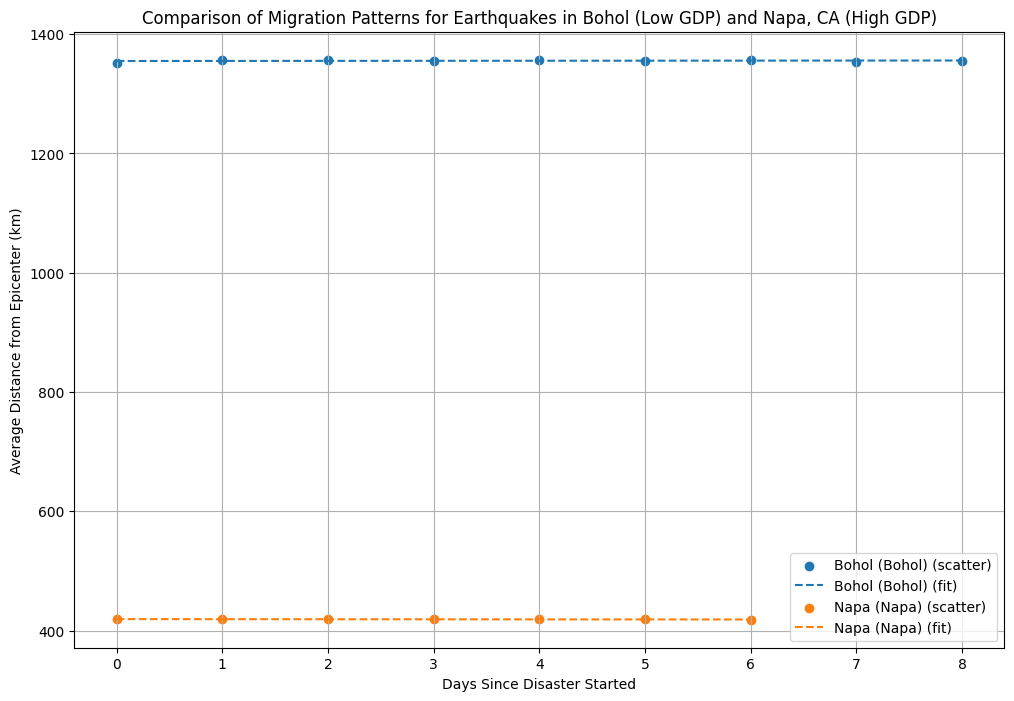

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

plt.figure(figsize=(12, 8))

for disaster_event in [disaster_1, disaster_2]:
    # Filter data for the current disaster
    df_event = df_avg_distance[df_avg_distance['disaster.event'] == disaster_event]

    # Extract X and y
    X = df_event[['days_since_disaster']]
    y = df_event['distance_from_epicenter']

    # Scatterplot of the average distances
    plt.scatter(df_event['days_since_disaster'], df_event['distance_from_epicenter'], label=f"{disaster_event} (scatter)")

    # Fit a linear regression line
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Plot the line of best fit
    plt.plot(df_event['days_since_disaster'], y_pred, label=f"{disaster_event} (fit)", linestyle='--')

# Add labels, legend, and title
plt.xlabel('Days Since Disaster Started')
plt.ylabel('Average Distance from Epicenter (km)')
plt.title('Comparison of Migration Patterns for Earthquakes in Bohol (Low GDP) and Napa, CA (High GDP)')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 9, 1))  # Show days 0-8
plt.show()


###Compare storms, one with a high GDP per capita and one with a low GDP per capita in the affected area. (Xaver (Norfolk, Britain)) vs (Storm (Baltimore, Maryland))

In [ ]:
#winter storm and thunderstorms
disaster_1='Xaver (Norfolk)' #high GDP
disaster_2='Storm (Baltimore)' #low GDP

df_two_disasters = df_merged[df_merged['disaster.event'].isin([disaster_1, disaster_2])]

In [ ]:
print(df_two_disasters.groupby('disaster.event')['distance_from_epicenter'].describe())

                     count         mean        std          min          25%  \
disaster.event                                                                 
Storm (Baltimore)  95172.0  1919.632902   3.841881  1911.893996  1917.054528   
Xaver (Norfolk)    32304.0  1874.125717  14.297884  1844.574921  1864.593384   

                           50%          75%          max  
disaster.event                                            
Storm (Baltimore)  1919.846209  1921.609709  1931.279541  
Xaver (Norfolk)    1874.985119  1880.475926  1915.221481  


In [ ]:
df_avg_distance = (
    df_two_disasters
    .groupby(['disaster.event', 'days_since_disaster'])
    .agg({'distance_from_epicenter': 'mean'})
    .reset_index()
)

In [ ]:
print(df_avg_distance.head())

      disaster.event  days_since_disaster  distance_from_epicenter
0  Storm (Baltimore)                    0              1919.134328
1  Storm (Baltimore)                    1              1919.519522
2  Storm (Baltimore)                    2              1919.545743
3  Storm (Baltimore)                    3              1919.478085
4  Storm (Baltimore)                    4              1919.845665


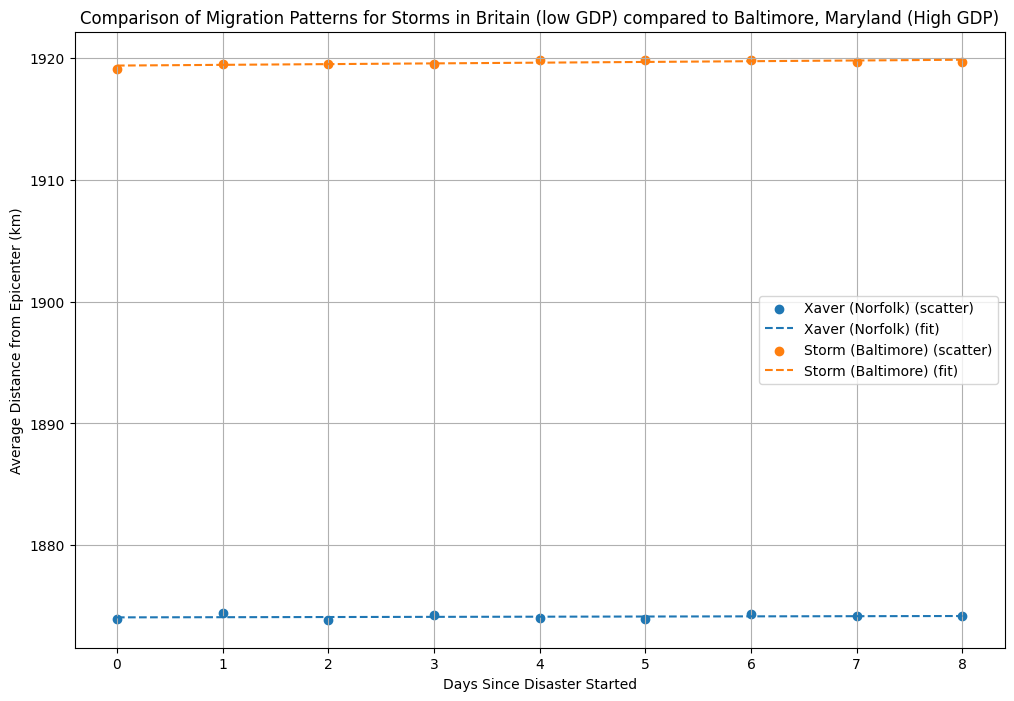

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

plt.figure(figsize=(12, 8))

for disaster_event in [disaster_1, disaster_2]:
    # Filter data for the current disaster
    df_event = df_avg_distance[df_avg_distance['disaster.event'] == disaster_event]

    # Extract X and y
    X = df_event[['days_since_disaster']]
    y = df_event['distance_from_epicenter']

    # Scatterplot of the average distances
    plt.scatter(df_event['days_since_disaster'], df_event['distance_from_epicenter'], label=f"{disaster_event} (scatter)")

    # Fit a linear regression line
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Plot the line of best fit
    plt.plot(df_event['days_since_disaster'], y_pred, label=f"{disaster_event} (fit)", linestyle='--')

# Add labels, legend, and title
plt.xlabel('Days Since Disaster Started')
plt.ylabel('Average Distance from Epicenter (km)')
plt.title('Comparison of Migration Patterns for Storms in Britain (low GDP) compared to Baltimore, Maryland (High GDP)')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 9, 1))  # Show days 0-8
plt.show()


#Checkpoint

So above is the last plot I have done, this actually doesn't tell much for me, so I have to change how we're analyzing these disaster.events. Maybe we should just compare a couple of disaster.events instead.

In [ ]:
df = df_Wipha  # Ensure df is the correct dataframe

In [ ]:
df['days_since_disaster'].unique()

array([11, 19,  5,  1,  3,  2,  7,  8,  9, 10, 12, 15, 16, 20, 22, 27,  0,
        6, 14, 17, 18, 21, 23, 28,  4, 13, 29])

In [ ]:
#make new dataframes for each day since the disaster in the df_Wipha
df_day_1 = df[df['days_since_disaster'] == 0]
df_day_1.head()
df_day_2 = df[df['days_since_disaster'] == 1]
df_day_2.head()
df_day_3 = df[df['days_since_disaster'] == 2]
df_day_3.head()
df_day_4 = df[df['days_since_disaster'] == 3]
df_day_4.head()

disaster.event  user.anon  longitude.anon   latitude                time  \
15   Wipha (Tokyo)          0      139.494139  24.403357 2013-10-12 23:54:11   
128  Wipha (Tokyo)          0      139.900664  24.672942 2013-10-12 10:43:27   
129  Wipha (Tokyo)          0      139.679714  24.557611 2013-10-12 11:34:11   
130  Wipha (Tokyo)          0      139.678491  24.552603 2013-10-12 11:45:12   
131  Wipha (Tokyo)          0      139.664683  24.596122 2013-10-12 14:01:42   

        Type      Location  year  distance_from_epicenter  \
15   Typhoon  Tokyo, Japan  2013              1255.105284   
128  Typhoon  Tokyo, Japan  2013              1225.149317   
129  Typhoon  Tokyo, Japan  2013              1237.810442   
130  Typhoon  Tokyo, Japan  2013              1238.367372   
131  Typhoon  Tokyo, Japan  2013              1233.530339   

     days_since_disaster    day  
15                     3  Day 4  
128                    3  Day 4  
129                    3  Day 4  
130                    3  Day 4  
131                    3  Day 4

In [ ]:
df_day_4.shape

(46769, 11)

In [ ]:
# Convert 'time' column to datetime with dynamic format handling
df['time'] = pd.to_datetime(df['time'], errors='coerce', format='mixed')

# Create a Mapbox plot with routes for all users separated by days

def create_mapbox_plot(df):
  fig = px.scatter_mapbox(
      df,
      lat='latitude',  # Ensure the column 'latitude' exists
      lon='longitude.anon',  # Ensure the column 'longitude.anon' exists
      #color="user.anon",  # Different colors for each user
      hover_data={"time": True},  # Add timestamp to hover info
      title="Migration Routes for All Users",
      mapbox_style="open-street-map",  # Change style to Open Street Map
      zoom=3,
      center={"lat":df_event_start_location.loc[df_event_start_location['disaster.event'] == 'Wipha (Tokyo)', 'latitude'].iloc[0], "lon":df_event_start_location.loc[df_event_start_location['disaster.event'] == 'Wipha (Tokyo)', 'longitude.anon'].iloc[0]}
  )

  fig.add_scattermapbox(
      lat=[df_event_start_location.loc[df_event_start_location['disaster.event'] == 'Wipha (Tokyo)', 'latitude'].iloc[0]],  # Extract latitude for Wipha (Tokyo)
      lon=[df_event_start_location.loc[df_event_start_location['disaster.event'] == 'Wipha (Tokyo)', 'longitude.anon'].iloc[0]],  # Extract longitude for Wipha (Tokyo)
      mode='markers',  # Set mode to 'markers' to show a point
      marker=dict(size=10, color='red'),  # Customize marker appearance
      name='Epicenter'  # Add a name for the epicenter trace
  )
  # Update layout for better display
  fig.update_layout(
      height=600,
      margin={"r": 0, "t": 30, "l": 0, "b": 0},
      legend_title="User"
  )
  fig.show()

create_mapbox_plot(df_day_1)
create_mapbox_plot(df_day_2)
create_mapbox_plot(df_day_3)
create_mapbox_plot(df_day_4)

##Additional question:

Does GDP per Capita matter for disaster migration?

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [ ]:
#load a new file with the GDP per capita for each disaster.event
df_gdp = pd.read_csv('/content/drive/MyDrive/Fall 2024 Classes/Data_science/final project death /GDP_per_Capita.csv')
df_gdp.head()

disaster.event  GDP per Capita (USD)
0        Wipha (Tokyo)                 43000
1     Halong (Okinawa)                 38475
2  Kalmaegi (Calasiao)                  2935
3    Rammasun (Manila)                  2935
4        Bohol (Bohol)                  2847

In [ ]:
df_gdp.shape

(15, 2)

In [ ]:
# Convert 'GDP per Capita (USD)' column from string to integers
df_gdp['GDP per Capita (USD)'] = pd.to_numeric(df_gdp['GDP per Capita (USD)'], errors='coerce').astype('Int64')
df_gdp.head()

disaster.event  GDP per Capita (USD)
0        Wipha (Tokyo)                 43000
1     Halong (Okinawa)                 38475
2  Kalmaegi (Calasiao)                  2935
3    Rammasun (Manila)                  2935
4        Bohol (Bohol)                  2847

In [ ]:
#merge GDP per Capita (USD) column from df_gdp into corresponding disaster.event in df_merged
df_merged = df_merged.merge(df_gdp[['disaster.event', 'GDP per Capita (USD)']], on='disaster.event', how='left')
df_merged.head()


disaster.event  user.anon  longitude.anon   latitude                time  \
0  Wipha (Tokyo)          0      139.738485  24.517249 2013-10-14 15:49:25   
1  Wipha (Tokyo)          0      139.697556  24.549073 2013-10-14 16:22:14   
2  Wipha (Tokyo)          0      139.642395  24.518733 2013-10-10 12:15:28   
3  Wipha (Tokyo)          0      139.494139  24.403357 2013-10-12 23:54:11   
4  Wipha (Tokyo)          0      139.589367  24.640273 2013-10-11 15:50:43   

      Type      Location  year  days_since_disaster  latitude_epicenter  \
0  Typhoon  Tokyo, Japan  2013                    5           35.689487   
1  Typhoon  Tokyo, Japan  2013                    5           35.689487   
2  Typhoon  Tokyo, Japan  2013                    1           35.689487   
3  Typhoon  Tokyo, Japan  2013                    3           35.689487   
4  Typhoon  Tokyo, Japan  2013                    2           35.689487   

   longitude.anon_epicenter  distance_from_epicenter  GDP per Capita (USD)  
0                139.691711              1238.517299                 43000  
1                139.691711              1234.984255                 43000  
2                139.691711              1238.353894                 43000  
3                139.691711              1251.268530                 43000  
4                139.691711              1224.921692                 43000

In [ ]:
df_day3 = df_merged[df_merged['days_since_disaster'] == 3]
df_day3.head()

disaster.event  user.anon  longitude.anon   latitude                time  \
3   Wipha (Tokyo)          0      139.494139  24.403357 2013-10-12 23:54:11   
34  Wipha (Tokyo)          0      139.900664  24.672942 2013-10-12 10:43:27   
35  Wipha (Tokyo)          0      139.679714  24.557611 2013-10-12 11:34:11   
36  Wipha (Tokyo)          0      139.678491  24.552603 2013-10-12 11:45:12   
37  Wipha (Tokyo)          0      139.664683  24.596122 2013-10-12 14:01:42   

       Type      Location  year  days_since_disaster  latitude_epicenter  \
3   Typhoon  Tokyo, Japan  2013                    3           35.689487   
34  Typhoon  Tokyo, Japan  2013                    3           35.689487   
35  Typhoon  Tokyo, Japan  2013                    3           35.689487   
36  Typhoon  Tokyo, Japan  2013                    3           35.689487   
37  Typhoon  Tokyo, Japan  2013                    3           35.689487   

    longitude.anon_epicenter  distance_from_epicenter  GDP per Capita (USD)  
3                 139.691711              1251.268530                 43000  
34                139.691711              1221.428365                 43000  
35                139.691711              1234.038999                 43000  
36                139.691711              1234.593783                 43000  
37                139.691711              1229.775412                 43000

Examine whether GDP is correlated with the average migration distance for disasters by creating a "disaster_summary" variable that calculates the averages for GDP per capita and distance from the epicenters.

A correlation coefficient will indicate whether there’s a linear relationship (positive or negative) between GDP and migration distance.

Below, we can see that the correlation coefficient shows a weak negative correlation between GDP per Capita (USD) and distance from the disaster epicenter.

In [ ]:
disaster_summary = df_day3.groupby('disaster.event').agg(
    avg_distance=('distance_from_epicenter', 'mean'),
    avg_gdp=('GDP per Capita (USD)', 'mean') # Changed 'GDP_per_capita (USD)' to 'GDP per Capita (USD)'
)

# Calculate correlation
correlation = disaster_summary.corr()
print(correlation)

              avg_distance   avg_gdp
avg_distance      1.000000 -0.241135
avg_gdp          -0.241135  1.000000


We can calculate the Pearson's R coefficient and its p-value. Since the p-value is not statistically significant at 0.38 compared to an alpha value of 0.05, the correlation coefficient could be showing an association where there may not be an association due to sampling errors.

In [ ]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(disaster_summary['avg_gdp'], disaster_summary['avg_distance'])
print(f"Pearson Correlation: {corr}")
print(f"P-value: {p_value}")


Pearson Correlation: -0.2411354641212551
P-value: 0.38661471513906603


The plot below shows a linear regression fitted around the distribution of GDP per Capita vs the migration distance, showing a slight negative correlation. However, the averages show an outlier (like San Francisco) for GDP. Otherwise, GDP doesn't seem to matter for the average migration distance (at day 3).

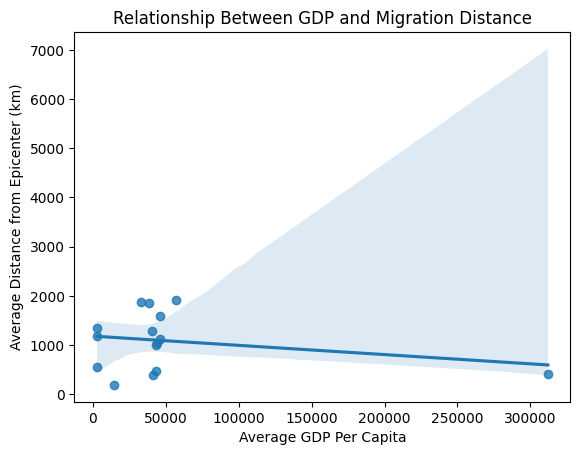

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
sns.regplot(x='avg_gdp', y='avg_distance', data=disaster_summary)
plt.xlabel('Average GDP Per Capita')
plt.ylabel('Average Distance from Epicenter (km)')
plt.title('Relationship Between GDP and Migration Distance')
plt.show()
